<a href="https://colab.research.google.com/github/megmarv/AI-BioLabs/blob/Diabetes-UT-Classification/SVM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
import keras
print("keras version:", keras.__version__)
print("keras location:", keras.__file__)

import tensorflow as tf
print("tensorflow version:", tf.__version__)
print("tf.keras location:", tf.keras.__file__)

keras version: 3.10.0
keras location: d:\GPU-Environment\tfenv\Lib\site-packages\keras\__init__.py
tensorflow version: 2.19.0
tf.keras location: d:\GPU-Environment\tfenv\Lib\site-packages\keras\_tf_keras\keras\__init__.py


In [ ]:
# Cell 2: Load EfficientNetB1 without global average pooling
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block7b_add').output)
feature_extractor.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,160,519 (23.50 MB)

 Trainable params: 6,101,024 (23.27 MB)

 Non-trainable params: 59,495 (232.41 KB)

In [ ]:
# Test the output shape
import numpy as np
dummy_input = np.zeros((1, 224, 224, 3))
features = feature_extractor.predict(dummy_input)
print("Feature shape:", features.shape)  # Should be (1, 7, 7, 1280)
print("Flattened features length:", features.flatten().shape[0])  # Should be 62720

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature shape: (1, 7, 7, 320)
Flattened features length: 15680


In [ ]:
# Cell 3: Feature extraction function
def extract_features(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(img_array)
    return features.flatten()

In [ ]:
# Cell 4: Dataset loading function with image paths
def load_dataset(base_dir):
    X, y, paths = [], [], []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

    for label_index, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(class_dir, file)
                try:
                    features = extract_features(path)
                    X.append(features)
                    y.append(label_index)
                    paths.append(path)
                except Exception as e:
                    print(f"Error processing {path}: {e}")

    return np.array(X), np.array(y), class_names, paths

In [ ]:
# Cell 5: Load training and testing datasets
dataset_base = "D:/GPU-Environment/QA - BIO LABS System/Diabetes Stage Classification/DFU_UT_Dataset"
train_dir = os.path.join(dataset_base, "balanced_training")
test_dir = os.path.join(dataset_base, "balanced_validation")

X_train, y_train, class_names, train_paths = load_dataset(train_dir)
X_test, y_test, _, test_paths = load_dataset(test_dir)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Number of classes: {len(class_names)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Cell 6: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Cell 7: Train SVM classifier with hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1]}
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
                   param_grid, cv=5, n_jobs=-1, verbose=3)
svm.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1]},
             verbose=3)

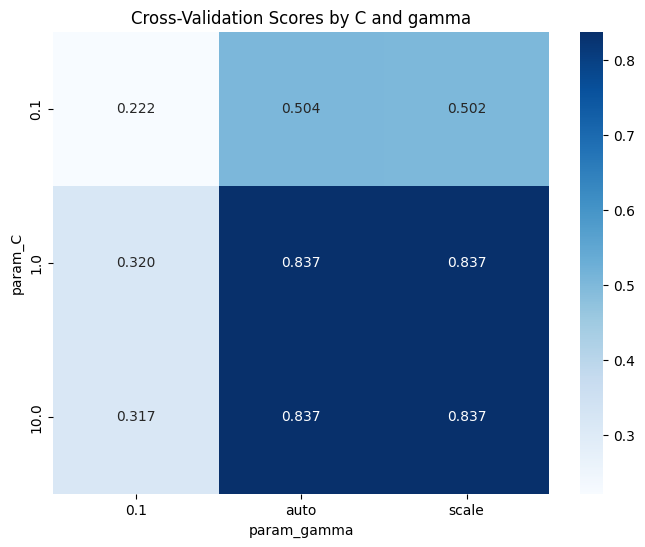

Best parameters: {'C': 1, 'gamma': 'scale'}
Best cross-validation score: 0.837


In [ ]:
# Visualize cross-validation results
results = pd.DataFrame(svm.cv_results_)
pivot_table = results.pivot(index='param_C', columns='param_gamma', values='mean_test_score')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.3f')
plt.title('Cross-Validation Scores by C and gamma')
plt.show()

print(f"Best parameters: {svm.best_params_}")
print(f"Best cross-validation score: {svm.best_score_:.3f}")

In [ ]:
# Cell 8: Evaluate classifier
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 89.00%

Classification Report:

                      precision    recall  f1-score   support

             Grade 0       0.78      0.90      0.84        20
             Grade 1       1.00      0.90      0.95        20
             Grade 2       0.85      0.85      0.85        20
             Grade 3       0.86      0.95      0.90        20
Normal(Healthy skin)       1.00      0.85      0.92        20

            accuracy                           0.89       100
           macro avg       0.90      0.89      0.89       100
        weighted avg       0.90      0.89      0.89       100



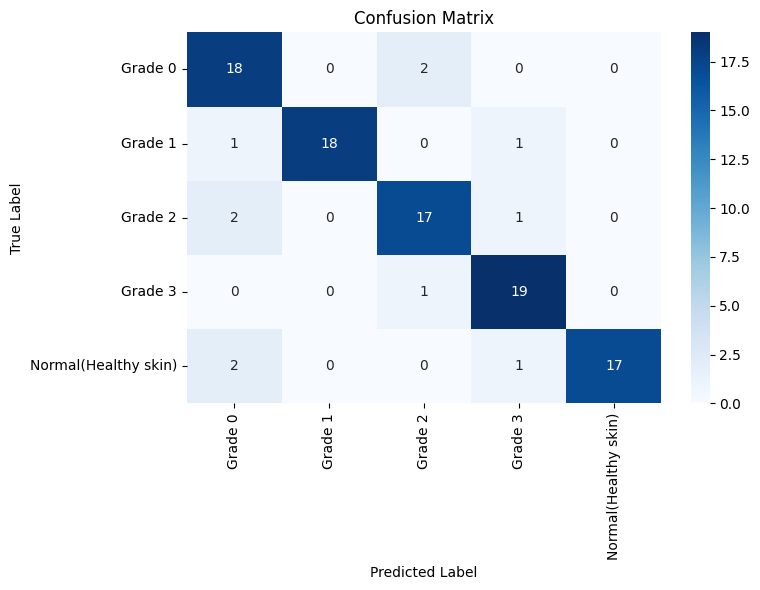

In [ ]:
# Cell 9: Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30416\3843843765.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=label_accuracies, palette='viridis')


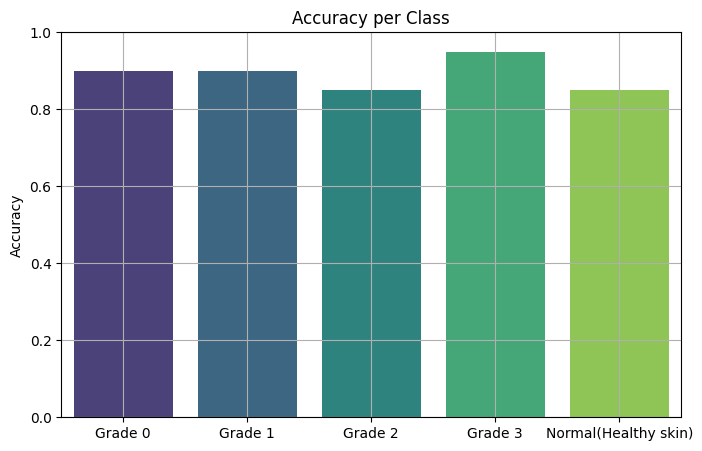

In [ ]:
# Cell 10: Accuracy bar plot
correct = (y_pred == y_test)
label_accuracies = []
for i, class_name in enumerate(class_names):
    indices = (y_test == i)
    acc = np.sum(correct[indices]) / np.sum(indices)
    label_accuracies.append(acc)

plt.figure(figsize=(8, 5))
sns.barplot(x=class_names, y=label_accuracies, palette='viridis')
plt.ylabel("Accuracy")
plt.title("Accuracy per Class")
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()

In [ ]:
# Cell 11: Save models
feature_extractor.save("svm_feature_extractor_v7.keras")
joblib.dump(svm, "svm_classifier_v7.joblib")
joblib.dump(scaler, "svm_scaler_v7.joblib")
print("Feature extractor, classifier, and scaler saved.")

Feature extractor, classifier, and scaler saved.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


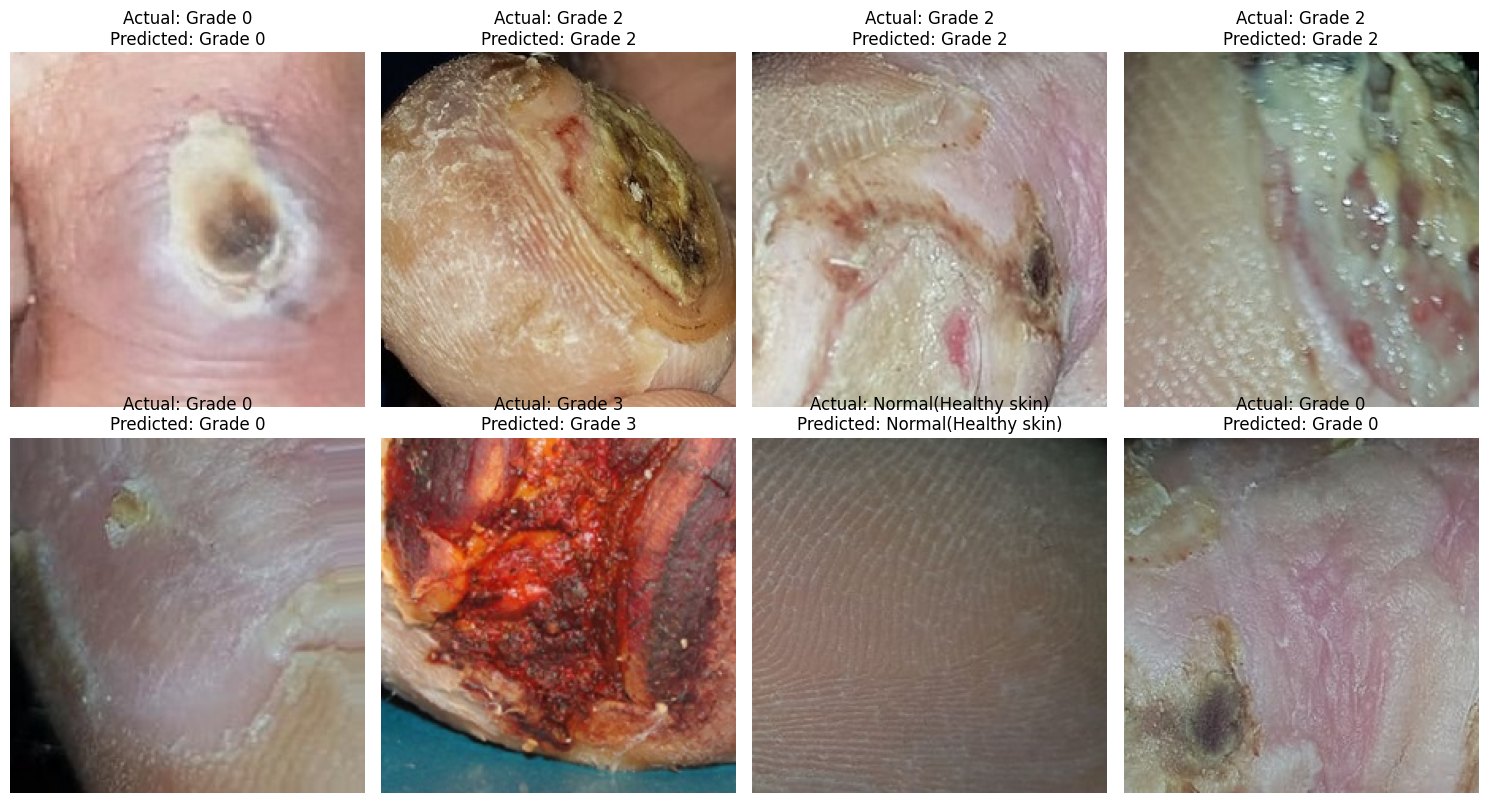

In [ ]:
# Cell 12: Display predictions on 8 random test images
indices = random.sample(range(len(test_paths)), 8)
selected_images = [test_paths[i] for i in indices]
selected_labels = y_test[indices]

features = np.array([extract_features(img) for img in selected_images])
features_scaled = scaler.transform(features)
predictions = svm.predict(features_scaled)

plt.figure(figsize=(15, 8))
for i in range(8):
    img_path = selected_images[i]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    actual = class_names[selected_labels[i]]
    predicted = class_names[predictions[i]]
    plt.title(f"Actual: {actual}\nPredicted: {predicted}")
    plt.axis('off')
plt.tight_layout()
plt.show()